# 09 - Tópicos Especiais

- Auto Arima com X
- Prophet
- Tratamento de outliers (além de criação de eventos)
- Considerações para modelos hierárquicos
- Redes Neurais, Gradient Boosting e outros métodos ML
- Métodos de cross-validation para séries temporais

In [1]:
from pathlib import Path
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from funcoes import all_ac, plot_forecast, teste_estacionariedade, diagnostico, compara_previsoes, correlacao_cruzada, compara_estatisticas

plt.rcParams["figure.figsize"] = [12, 5]

## Auto ARIMA com X

In [ ]:
df = pd.read_csv('../../dados/clicks_original.csv')
df.index = pd.to_datetime(df['date'], format='mixed')
df = df.drop(['date'], axis=1)
df.index.freq = 'D'
df = df[:-1] # Tirando o último ponto por ser um outlier, vou discutir isso depois
df['price_4'] = df['price'].shift(4)
df = df.dropna()
y = df['clicks']
x = df['price_4']
x

date
2008-04-05    43.155647
2008-04-06    43.079056
2008-04-07    43.842609
2008-04-08    43.312376
2008-04-09    43.941176
                ...    
2008-08-08    44.237583
2008-08-09    43.801770
2008-08-10    43.917176
2008-08-11    44.254605
2008-08-12    43.730836
Freq: D, Name: price_4, Length: 130, dtype: float64

Auto Arima necessita de um array 2d, transformando:

In [3]:
x = x.values.reshape(-1, 1)
x

array([[43.15564682],
       [43.07905583],
       [43.84260922],
       [43.31237591],
       [43.94117647],
       [44.40393627],
       [43.99588759],
       [43.37377342],
       [43.3203125 ],
       [43.15473756],
       [42.92165899],
       [42.71320755],
       [43.54693367],
       [44.4093473 ],
       [42.20701754],
       [43.18156028],
       [44.05149254],
       [42.34208754],
       [42.2296764 ],
       [43.30626655],
       [43.24743777],
       [42.87278583],
       [43.53069153],
       [43.41507634],
       [42.26779661],
       [42.41653418],
       [44.22765197],
       [42.64935065],
       [42.37521968],
       [42.90316004],
       [43.22430939],
       [44.03172205],
       [43.03038674],
       [43.10958904],
       [43.87172012],
       [43.56942949],
       [42.98898072],
       [42.45890411],
       [42.87135922],
       [42.5762987 ],
       [43.40588988],
       [43.25832583],
       [42.71447903],
       [43.37278583],
       [42.51775487],
       [44

In [4]:
auto_model = auto_arima(y, X=x,
                           information_criterion='bic',
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=2596.044, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=2591.052, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=2593.636, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=2591.284, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=2593.403, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=2597.256, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=2600.978, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=2586.271, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=2588.747, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=2533.463, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=2589.056, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=2596.424, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=2

In [5]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1257.012
Date:                Tue, 01 Apr 2025   AIC                           2522.023
Time:                        17:05:52   BIC                           2533.463
Sample:                    04-05-2008   HQIC                          2526.671
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           280.6459    203.660      1.378      0.168    -118.521     679.813
ar.L1         -0.0011      0.105     -0.010      0.992      -0.207       0.205
ma.L1         -0.8966      0.046    -19.450      0.000      -0.987      -0.806
sigma2      1.703e+07      0.011   1.49e+09      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               143.46
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             1.48
Prob(H) (two-sided):                  0.78   Kurtosis:                         7.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+24. Standard errors may be unstable.
"""

In [6]:
x = df[['price', 'price_4']]
x

,price,price_4
date,,
2008-04-05,43.941176,43.155647
2008-04-06,44.403936,43.079056
2008-04-07,43.995888,43.842609
2008-04-08,43.373773,43.312376
2008-04-09,43.320312,43.941176
...,...,...
2008-08-08,43.730836,44.237583
2008-08-09,44.182033,43.801770
2008-08-10,43.608260,43.917176


In [7]:
auto_model = auto_arima(y, X=x,
                           information_criterion='bic',
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=2548.227, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=2549.530, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=2549.926, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2543.361, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=2550.749, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.132 seconds


In [8]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:                        SARIMAX   Log Likelihood               -1264.379
Date:                Tue, 01 Apr 2025   AIC                           2534.759
Time:                        17:05:53   BIC                           2543.361
Sample:                    04-05-2008   HQIC                          2538.254
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price      -1285.2628    411.116     -3.126      0.002   -2091.035    -479.490
price_4     1497.7165    411.910      3.636      0.000     690.389    2305.044
sigma2      1.634e+07   1.88e+06      8.692      0.000    1.27e+07       2e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.60   Jarque-Bera (JB):                92.09
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             1.45
Prob(H) (two-sided):                  0.61   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Último exemplo de Auto ARIMA

In [ ]:
file = Path('../../dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('D').mean().dropna()
apple = pd.Series(closing_price['AAPL'], name='Preço de Fechamento Apple')
microsoft = pd.Series(closing_price['MSFT'], name='Preço de Fechamento Microsoft')
ibm = pd.Series(closing_price['IBM'], name='Preço de Fechamento IBM')
closing_price

,AAPL,MSFT,IBM
Date,,,
2019-11-01,62.830273,140.552994,115.847458
2019-11-04,63.242901,141.364731,117.676682
2019-11-05,63.152027,141.276733,117.864746
2019-11-06,63.179031,140.885513,118.625488
2019-11-07,63.908203,141.081116,119.083855
...,...,...,...
2021-10-26,149.102402,309.543671,119.938713
2021-10-27,148.633087,322.579865,118.089584
2021-10-28,152.347656,323.757690,118.721680


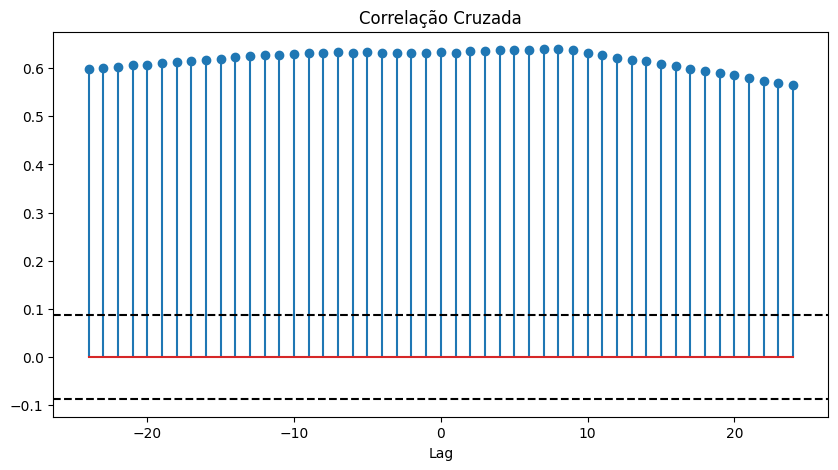

In [10]:
correlacao_cruzada(microsoft, ibm)

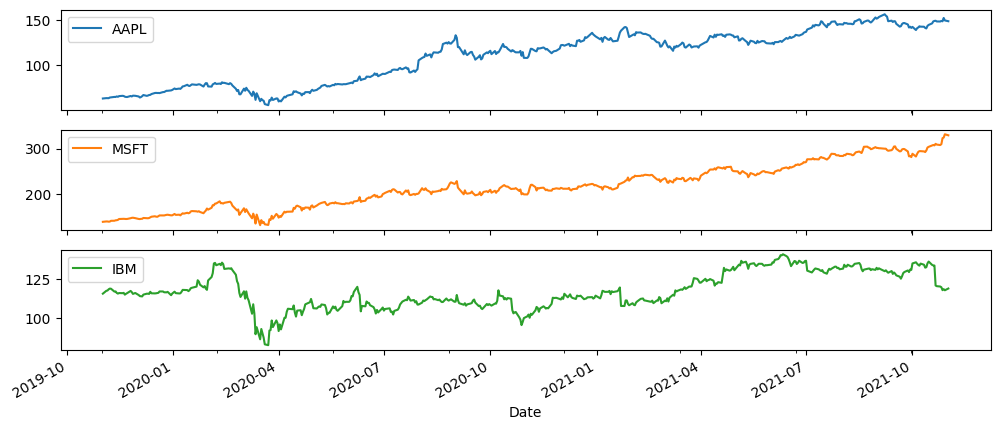

In [11]:
closing_price.plot(subplots=True)
plt.show()

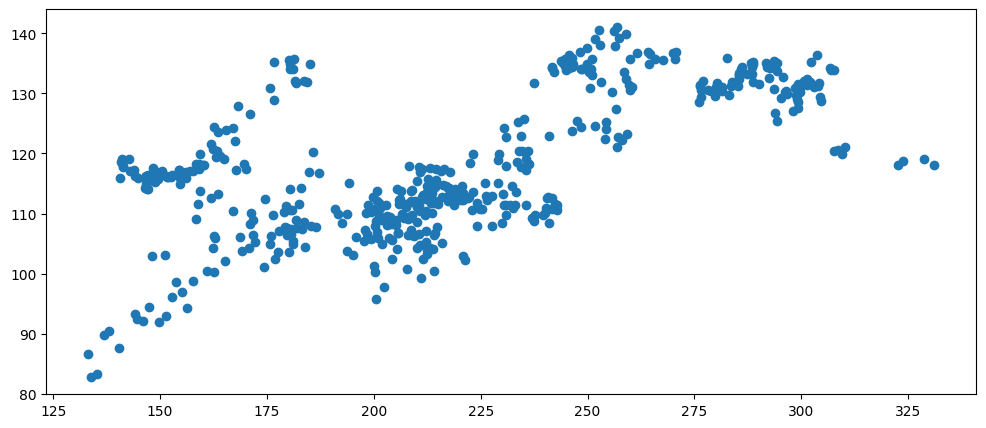

In [12]:
plt.scatter(x=microsoft, y=ibm)
plt.show()

In [13]:
primeira_ordem = closing_price.diff(1).dropna()
primeira_ordem

,AAPL,MSFT,IBM
Date,,,
2019-11-04,0.412628,0.811737,1.829224
2019-11-05,-0.090874,-0.087997,0.188065
2019-11-06,0.027004,-0.391220,0.760742
2019-11-07,0.729172,0.195602,0.458366
2019-11-08,0.174904,1.662537,-0.069199
...,...,...,...
2021-10-26,0.679016,1.976349,-0.481155
2021-10-27,-0.469315,13.036194,-1.849129
2021-10-28,3.714569,1.177826,0.632095


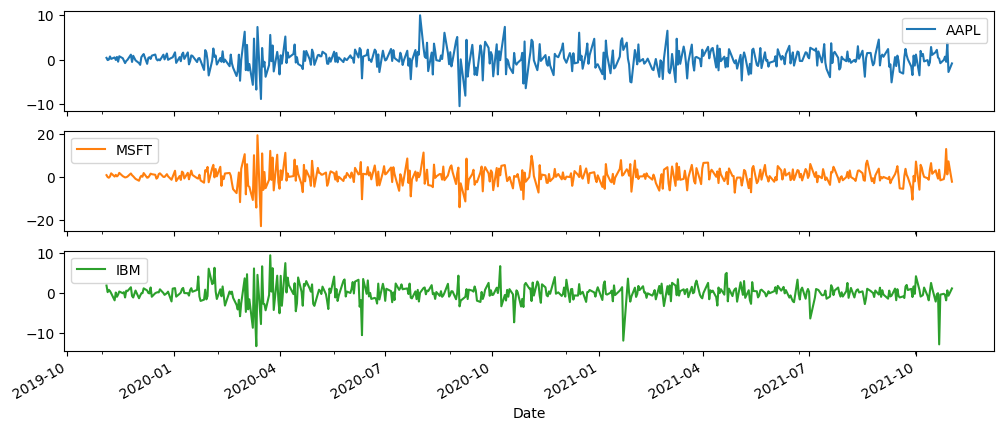

In [14]:
primeira_ordem.plot(subplots=True) 
plt.show()

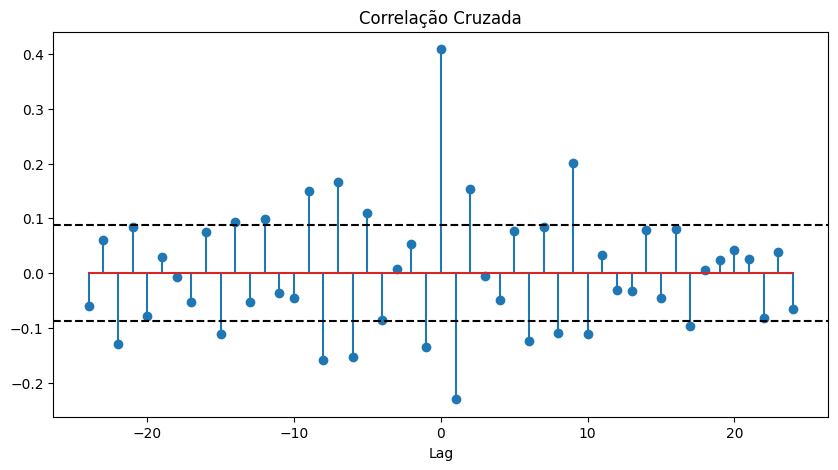

In [15]:
correlacao_cruzada(primeira_ordem['MSFT'], primeira_ordem['IBM'])

In [16]:
primeira_ordem['IBM_1'] = primeira_ordem['IBM'].shift(1)
primeira_ordem = primeira_ordem.dropna()
primeira_ordem

,AAPL,MSFT,IBM,IBM_1
Date,,,,
2019-11-05,-0.090874,-0.087997,0.188065,1.829224
2019-11-06,0.027004,-0.391220,0.760742,0.188065
2019-11-07,0.729172,0.195602,0.458366,0.760742
2019-11-08,0.174904,1.662537,-0.069199,0.458366
2019-11-11,0.507469,0.146683,-1.850815,-0.069199
...,...,...,...,...
2021-10-26,0.679016,1.976349,-0.481155,-0.226418
2021-10-27,-0.469315,13.036194,-1.849129,-0.481155
2021-10-28,3.714569,1.177826,0.632095,-1.849129


In [17]:
y = primeira_ordem['MSFT']
x = primeira_ordem['IBM_1'].values.reshape(-1, 1)
auto_model = auto_arima(y, X=x,
                           information_criterion='bic',
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=2803.800, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=2804.133, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=2800.739, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=2802.204, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2802.587, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=2805.328, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=2805.353, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=2811.462, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=2800.860, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.376 seconds


In [18]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  502
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1387.932
Date:                Tue, 01 Apr 2025   AIC                           2783.864
Time:                        17:05:53   BIC                           2800.739
Sample:                             0   HQIC                          2790.485
                                - 502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4359      0.181      2.402      0.016       0.080       0.792
x1            -0.2556      0.063     -4.044      0.000      -0.380      -0.132
ar.L1         -0.1619      0.035     -4.618      0.000      -0.231      -0.093
sigma2        14.7560      0.624     23.655      0.000      13.533      15.979
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               215.24
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
fitted_values = auto_model.predict_in_sample(X=x)
fitted_values

Date
2019-11-05   -0.092441
2019-11-06    0.326399
2019-11-07    0.296979
2019-11-08    0.255607
2019-11-11    0.165563
                ...   
2021-10-26    0.677773
2021-10-27    0.248422
2021-10-28   -1.181372
2021-10-29    0.160207
2021-11-01   -0.586265
Name: predicted_mean, Length: 502, dtype: float64

In [20]:
closing_price

,AAPL,MSFT,IBM
Date,,,
2019-11-01,62.830273,140.552994,115.847458
2019-11-04,63.242901,141.364731,117.676682
2019-11-05,63.152027,141.276733,117.864746
2019-11-06,63.179031,140.885513,118.625488
2019-11-07,63.908203,141.081116,119.083855
...,...,...,...
2021-10-26,149.102402,309.543671,119.938713
2021-10-27,148.633087,322.579865,118.089584
2021-10-28,152.347656,323.757690,118.721680


### Último mesmo

In [ ]:
milk_file = Path('../../dados/milk_production.csv')

milk_prod = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)
periodos = 24
train = milk_prod[:-periodos]
test = milk_prod[-periodos:]
train

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1973-08-01,837
1973-09-01,784
1973-10-01,791


In [22]:
auto_model = auto_arima(train, 
                           seasonal=True, 
                           m=12, 
                           test='adf',
                           stepwise=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -451.814
Date:                            Tue, 01 Apr 2025   AIC                            909.628
Time:                                    17:05:56   BIC                            918.253
Sample:                                01-01-1962   HQIC                           913.133
                                     - 12-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2784      0.084     -3.309      0.001      -0.443      -0.114
ma.S.L12      -0.6361      0.082     -7.765      0.000      -0.797      -0.476
sigma2        55.2574      5.688      9.716      0.000      44.110      66.405
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                34.99
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.80
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

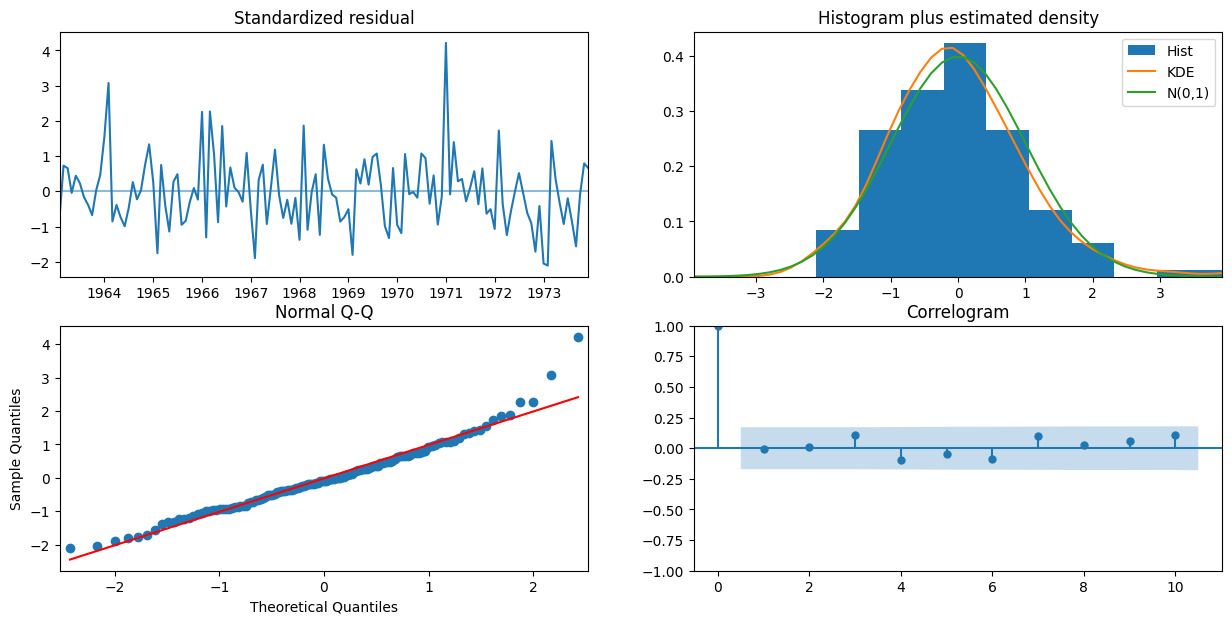

In [23]:
auto_model.plot_diagnostics(figsize=(15,7)); plt.show()

In [24]:
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

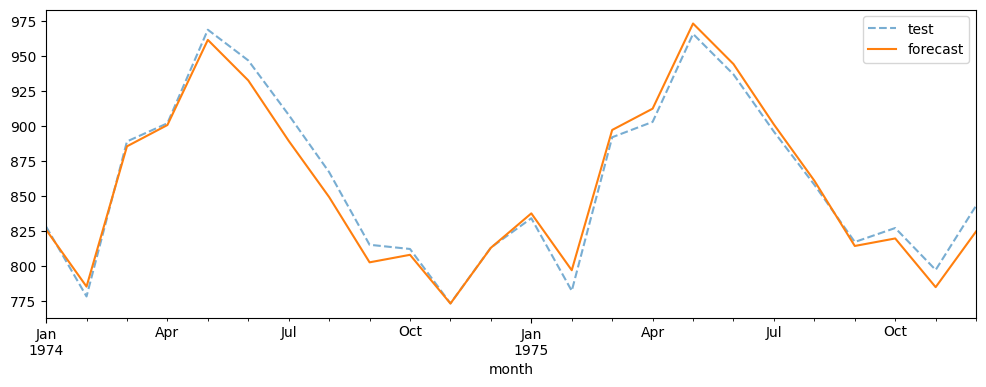

In [25]:
n = test.shape[0]
index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(auto_model.predict(n_periods=n), 
          index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show()

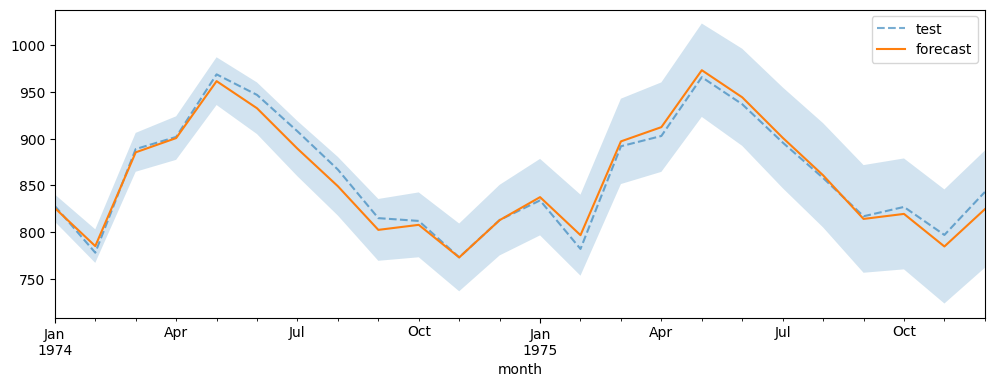

In [26]:
n = test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, return_conf_int=True)
lower_ci, upper_ci  = zip(*conf_interval)

index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']); plt.show()

## Prophet

$$
\large y(t) = g(t) + s(t) + h(t) + \epsilon _t
$$



In [27]:
from prophet import Prophet

Primeira coisa: o Prophet precisa de colunas com nomes específicos (ds e y)

In [28]:
milk_file = Path(milk_file)
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y']
milk

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


Nada de mais, só criando holdout:

In [29]:
periodos = 24
train = milk[:-periodos]
test = milk[-periodos:]
train

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
139,1973-08-01,837
140,1973-09-01,784
141,1973-10-01,791
142,1973-11-01,760


O ajuste acontece de forma automática após ele reconhecer pelo nome as colunas e os seus papéis na análise:

In [30]:
model = Prophet().fit(train)

17:05:56 - cmdstanpy - INFO - Chain [1] start processing
17:05:56 - cmdstanpy - INFO - Chain [1] done processing


Para fazer previsões precisamos extender a tabela, adicionando novos ds e deixando o y vazio:

In [31]:
future = model.make_future_dataframe(len(test), freq='MS')
future

,ds
0,1962-01-01
1,1962-02-01
2,1962-03-01
3,1962-04-01
4,1962-05-01
...,...
163,1975-08-01
164,1975-09-01
165,1975-10-01
166,1975-11-01


Reparem que a tabela furure tem o mesmo length da tabela original (train + test)

In [32]:
len(milk) == len(future)

True

In [33]:
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,607.729673,578.696649,597.506378,607.729673,607.729673,-19.878179,-19.878179,-19.878179,-19.878179,-19.878179,-19.878179,0.0,0.0,0.0,587.851494
1,1962-02-01,609.415288,539.983028,557.891146,609.415288,609.415288,-60.356482,-60.356482,-60.356482,-60.356482,-60.356482,-60.356482,0.0,0.0,0.0,549.058806
2,1962-03-01,610.937779,632.023682,650.805634,610.937779,610.937779,30.448739,30.448739,30.448739,30.448739,30.448739,30.448739,0.0,0.0,0.0,641.386517
3,1962-04-01,612.623393,650.185910,668.656971,612.623393,612.623393,46.819625,46.819625,46.819625,46.819625,46.819625,46.819625,0.0,0.0,0.0,659.443018
4,1962-05-01,614.254633,712.641382,730.905723,614.254633,614.254633,107.596744,107.596744,107.596744,107.596744,107.596744,107.596744,0.0,0.0,0.0,721.851378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1975-08-01,856.989890,826.860245,859.947876,843.872492,871.677921,-13.982407,-13.982407,-13.982407,-13.982407,-13.982407,-13.982407,0.0,0.0,0.0,843.007483
164,1975-09-01,857.246373,785.245905,820.460800,843.304011,872.868178,-55.132936,-55.132936,-55.132936,-55.132936,-55.132936,-55.132936,0.0,0.0,0.0,802.113437
165,1975-10-01,857.494583,788.793361,825.965534,842.495575,874.234908,-51.008625,-51.008625,-51.008625,-51.008625,-51.008625,-51.008625,0.0,0.0,0.0,806.485957
166,1975-11-01,857.751066,755.548810,795.989703,841.585950,876.045281,-82.198782,-82.198782,-82.198782,-82.198782,-82.198782,-82.198782,0.0,0.0,0.0,775.552284


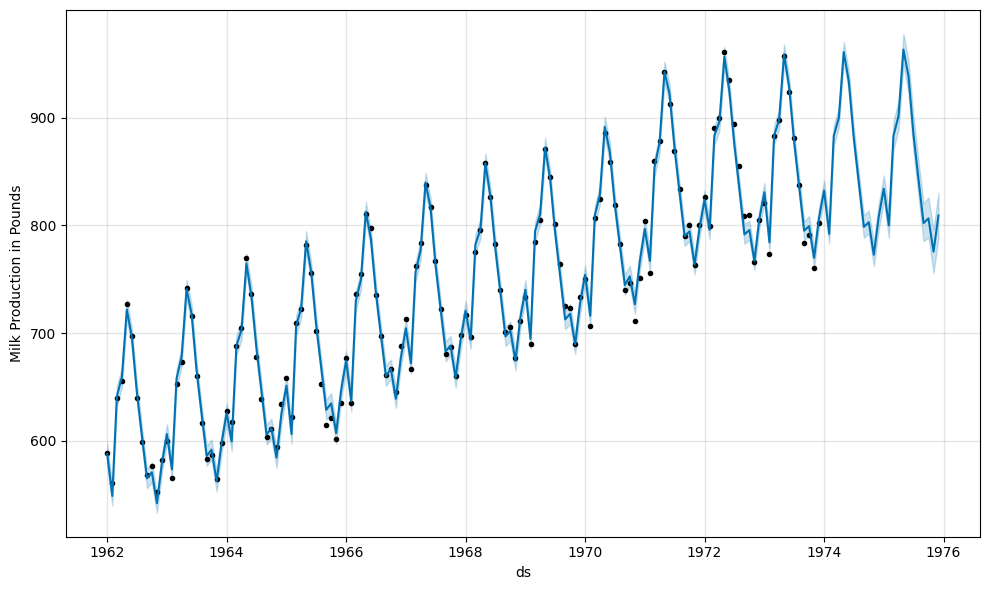

In [34]:
model.plot(forecast, ylabel='Milk Production in Pounds')
plt.show()

In [35]:
pd.concat([forecast['yhat'].iloc[-5:], test['y'].iloc[-5:]], axis=1)

,yhat,y
163,843.007483,858
164,802.113437,817
165,806.485957,827
166,775.552284,797
167,809.146834,843


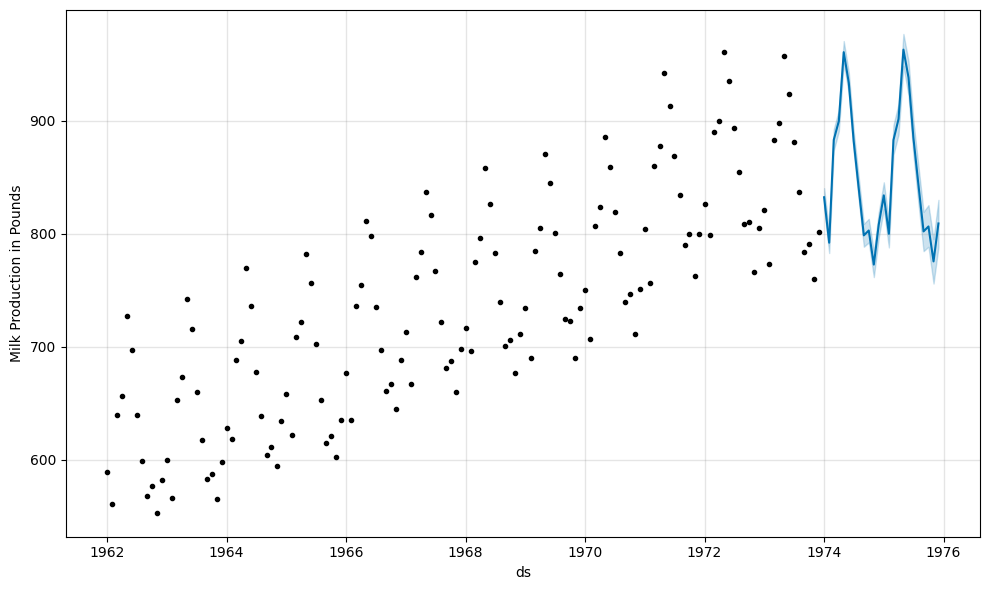

In [36]:
predicted = model.predict(test)
model.plot(predicted, ylabel='Milk Production in Pounds')
plt.show()

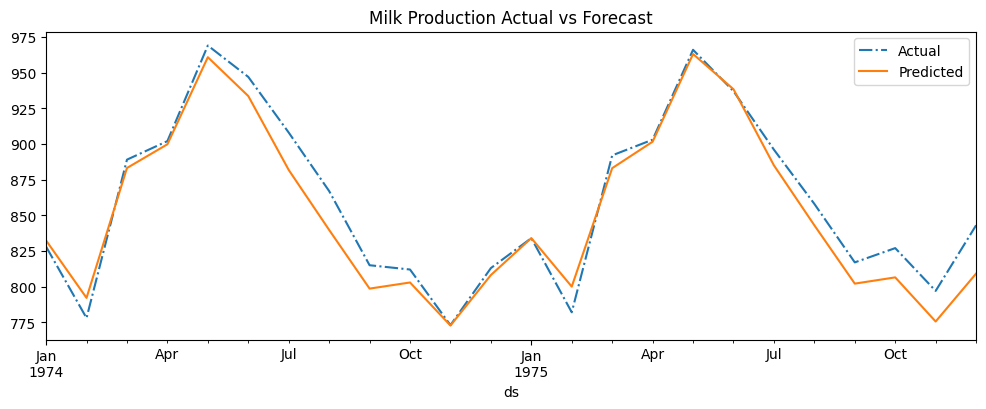

In [37]:
ax = test.plot(x='ds', y='y', 
                    label='Actual', 
                    style='-.', 
                    figsize=(12,4))
predicted.plot(x='ds', y='yhat', 
               label='Predicted', 
               ax=ax)
plt.title('Milk Production Actual vs Forecast')
plt.show()

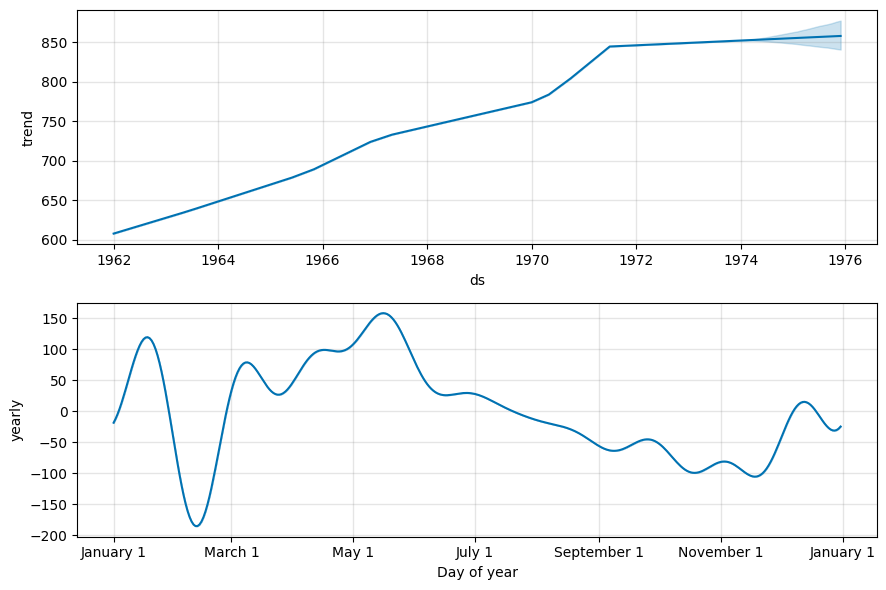

In [38]:
model.plot_components(forecast)
plt.show()

## Outliers


In [39]:
file = Path("../dados/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

nyc_taxi.index.freq = '30T'
nyc_taxi

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


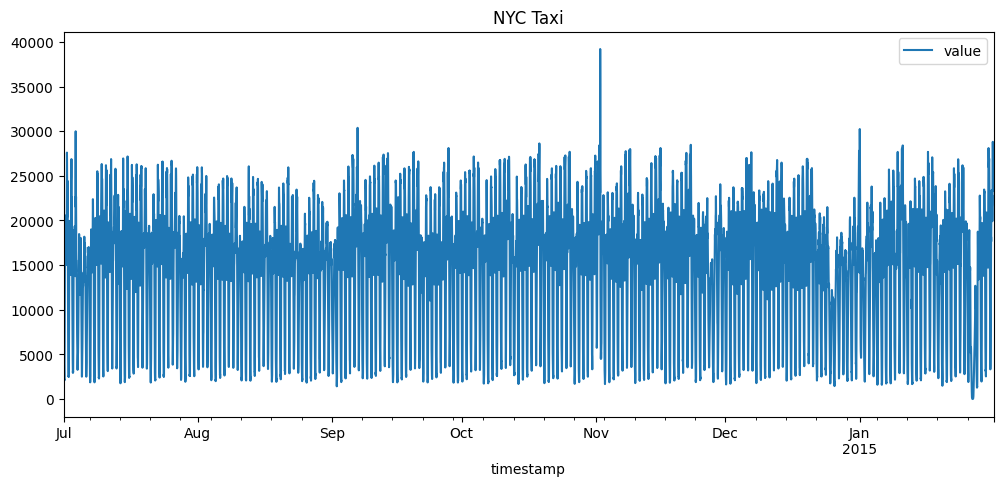

In [40]:
nyc_taxi.plot(title="NYC Taxi")
plt.show()

## Resampling

O **reamostramento (resampling)** é um método eficaz para contornar os efeitos de outliers em séries temporais porque ele permite ajustar a granularidade dos dados, suavizando o impacto de valores extremos. Aqui estão os principais motivos:

1. **Redução do Ruído**: Ao reamostrar os dados em uma frequência maior (por exemplo, de diário para semanal ou mensal), os outliers são diluídos no cálculo de agregações, como médias, somas ou medianas, reduzindo seu impacto nos padrões gerais da série.

2. **Foco em Tendências e Sazonalidades**: O reamostramento ajuda a destacar tendências e padrões sazonais ao minimizar a influência de flutuações pontuais causadas por outliers.

3. **Flexibilidade no Tratamento**: Durante o processo de reamostragem, é possível aplicar métodos robustos, como o uso de medianas ou percentis, que são menos sensíveis a valores extremos, garantindo uma representação mais confiável dos dados.

Em resumo, o reamostramento é uma abordagem prática para suavizar os efeitos de outliers, permitindo que os modelos de séries temporais capturem os padrões subjacentes sem serem excessivamente influenciados por valores anômalos.


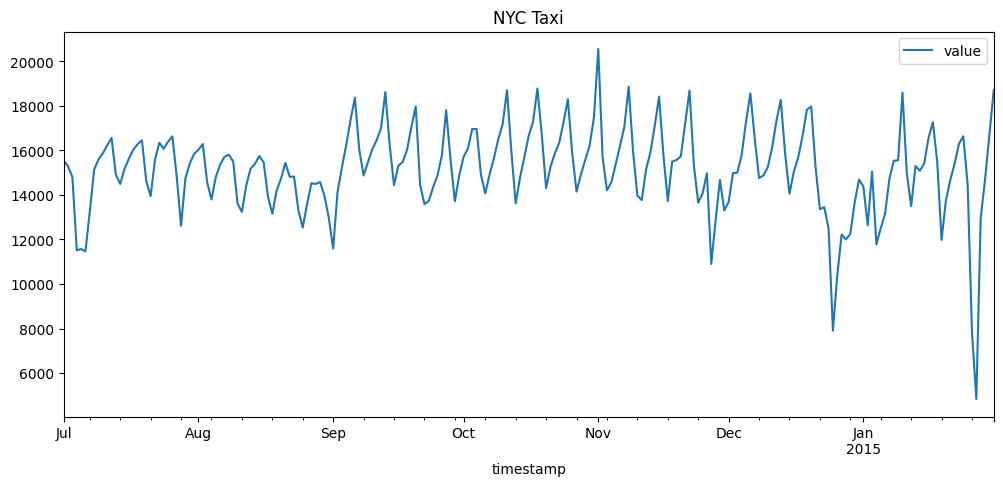

In [41]:
tx = nyc_taxi.resample('D').mean()
tx.plot(title="NYC Taxi")
plt.show()

Outliers que já esperamos:

- Sábado, 1º de novembro de 2014, foi antes da Maratona de Nova York, e o evento oficial da maratona ocorreu no domingo, 2 de novembro de 2014.
- Quinta-feira, 27 de novembro de 2014, foi o Dia de Ação de Graças.
- Quinta-feira, 25 de dezembro de 2014, foi o Dia de Natal.
- Quinta-feira, 1º de janeiro de 2015, foi o Dia de Ano Novo.
- Terça-feira, 27 de janeiro de 2015, foi a Nevasca da América do Norte, quando todos os veículos foram proibidos de circular nas ruas de 26 a 27 de janeiro de 2015.

In [42]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

In [43]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

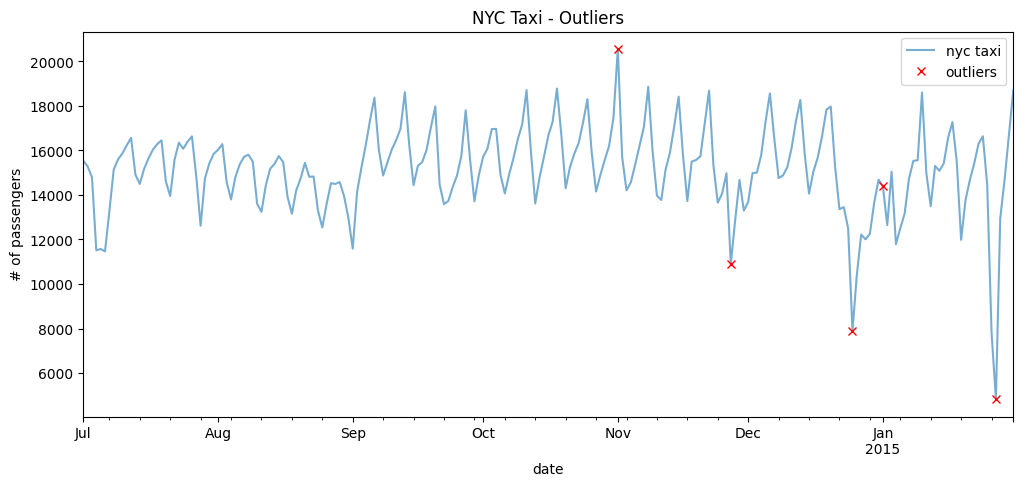

In [44]:
known_outliers = tx.loc[nyc_dates]
plot_outliers(known_outliers, tx, 'Outliers')

## Métodos Visuais

Box-Plot, Histogramas e Boxen Plots

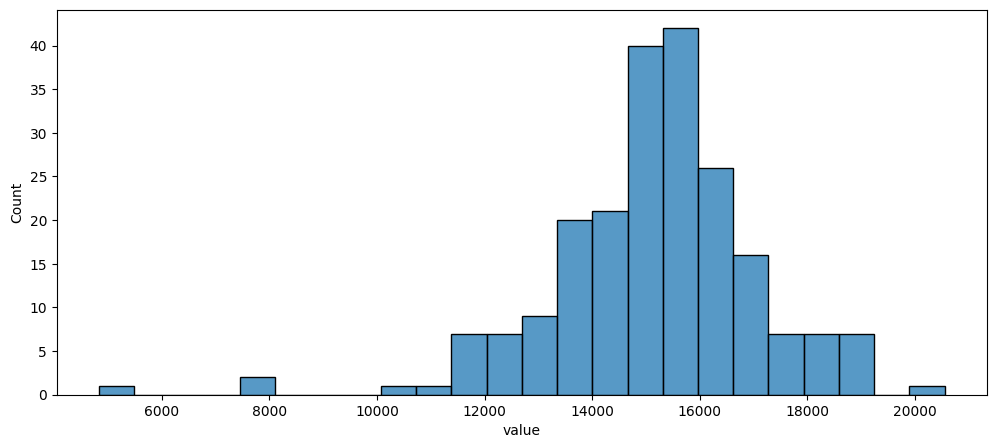

In [45]:
sns.histplot(tx['value'])
plt.show()

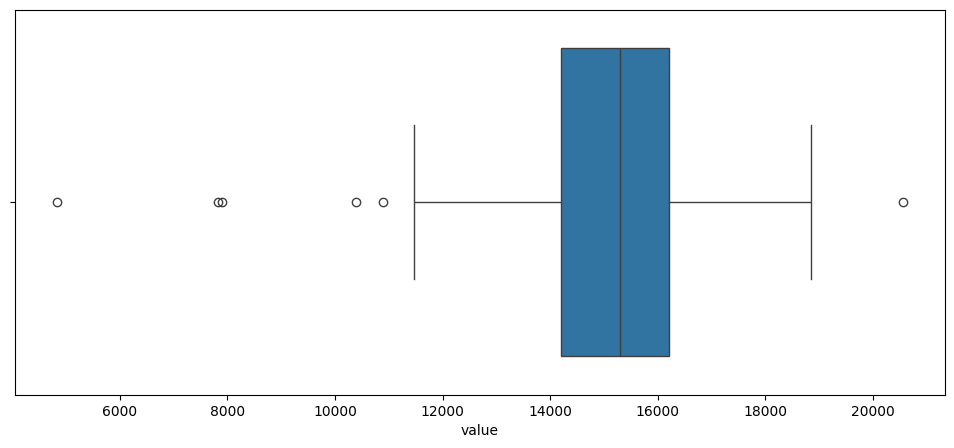

In [46]:
sns.boxplot(tx['value'], orient='h')
plt.show()

In [47]:
p25 = tx['value'].quantile(0.25)
p75 = tx['value'].quantile(0.75)
iiq = p75-p25

limite_inferior = p25-1.5*iiq
limite_superior = p75+1.5*iiq

In [48]:
tx[tx['value']<limite_inferior]

,value
timestamp,
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


In [49]:
tx[tx['value']>limite_superior]

,value
timestamp,
2014-11-01,20553.5


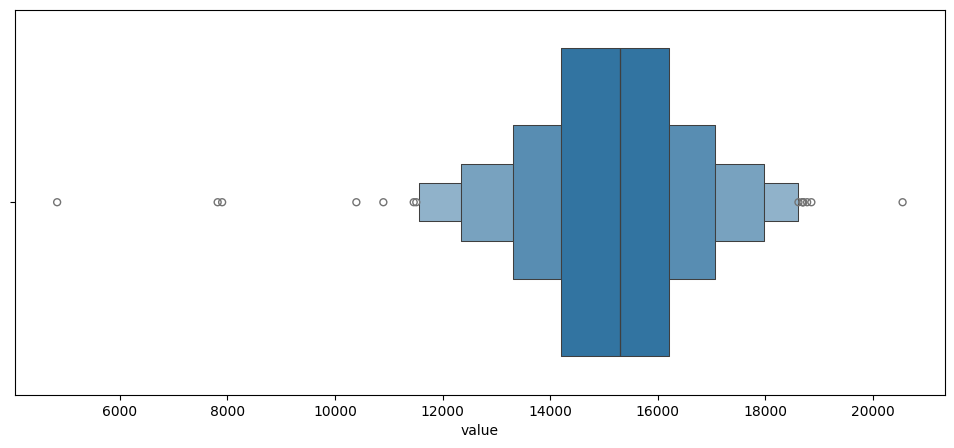

In [50]:
sns.boxenplot(tx['value'], orient='h')
plt.show()

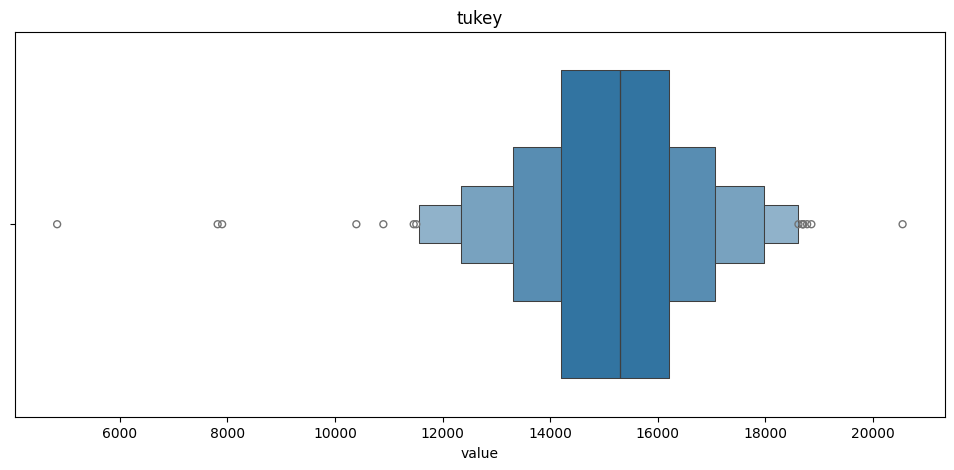

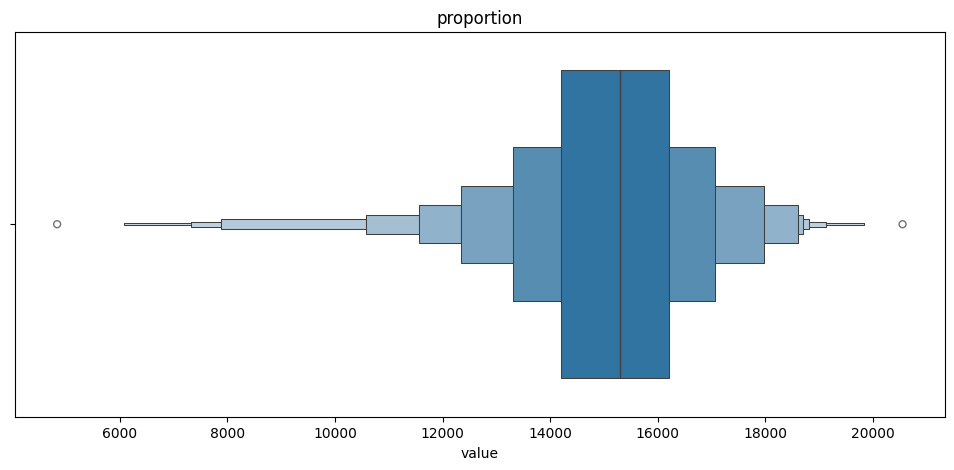

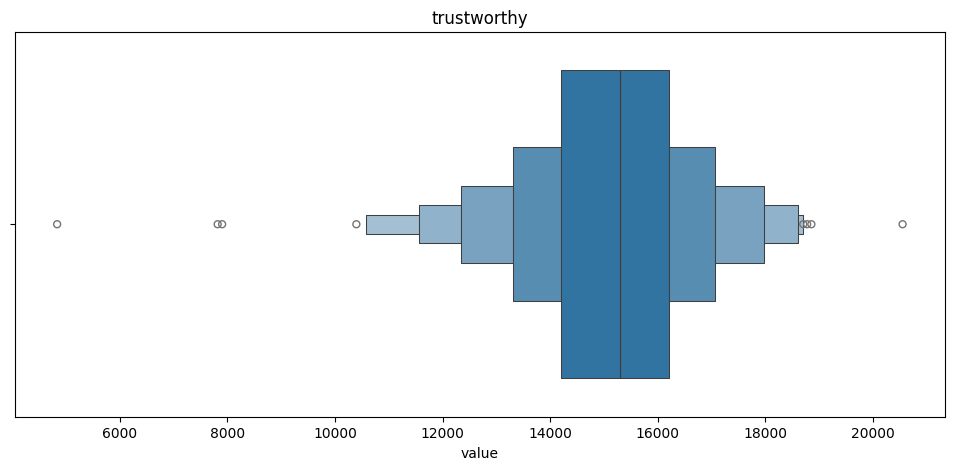

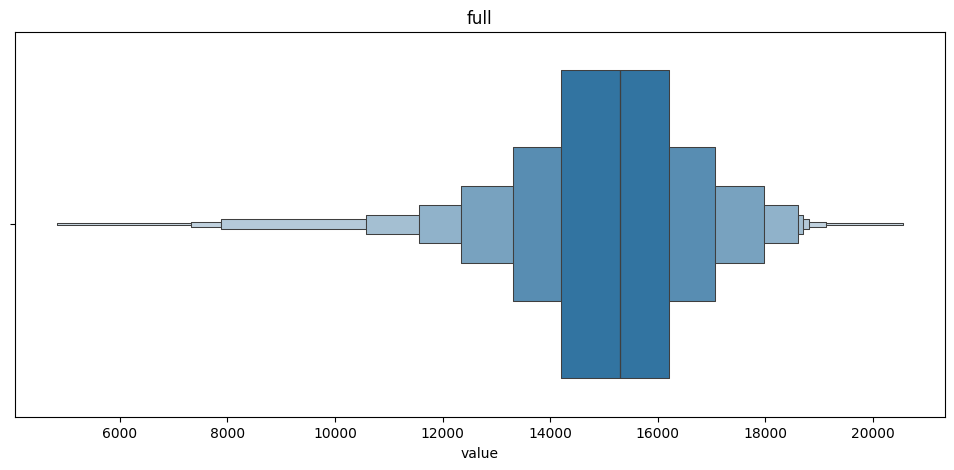

In [51]:
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(tx['value'], k_depth=k, orient='h')
    plt.title(k)
    plt.show()

https://vita.had.co.nz/papers/letter-value-plot.pdf

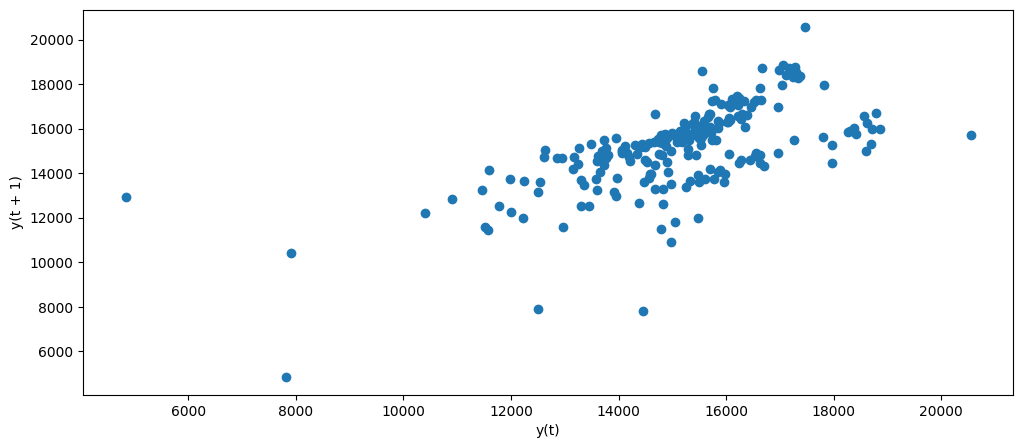

In [52]:
from pandas.plotting import lag_plot
lag_plot(tx, lag=1)
plt.show()

## Tukey
Mesma ideia do box plot, mas segue uma função para ajudar:

In [53]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [54]:
outliers = iqr_outliers(tx)
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


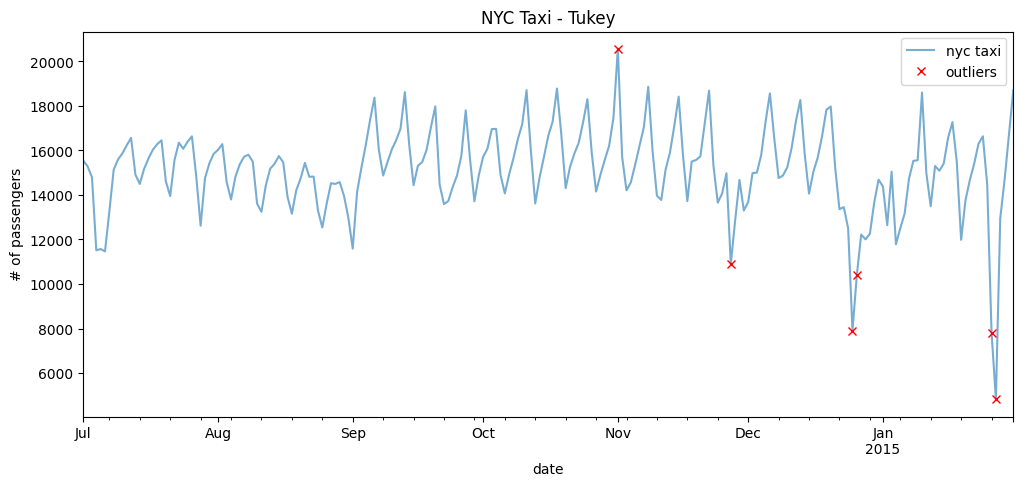

In [55]:
plot_outliers(outliers, tx, "Tukey")

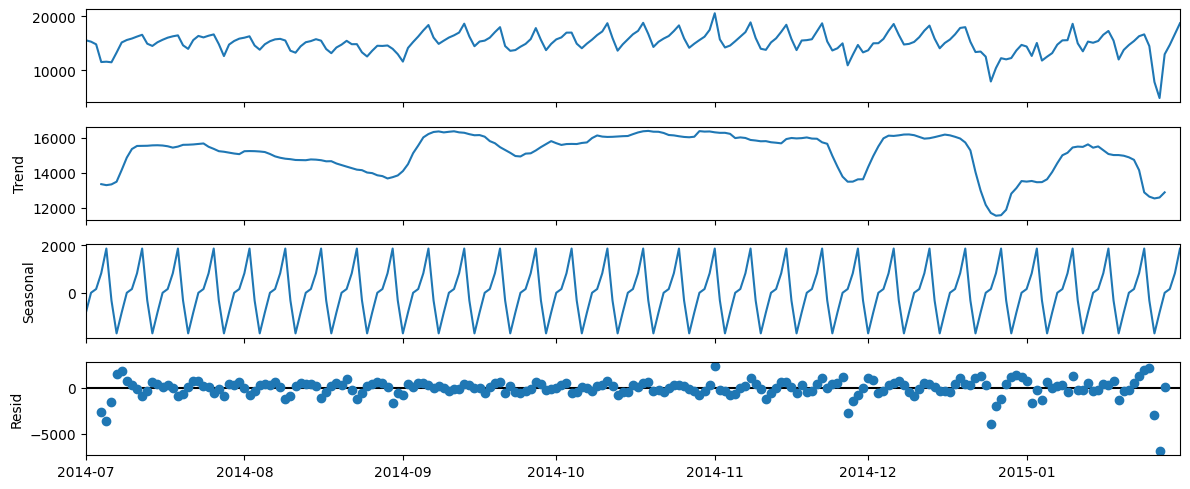

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
tx_decomposed = seasonal_decompose(tx,model='additive')
tx_decomposed.plot()
plt.show()

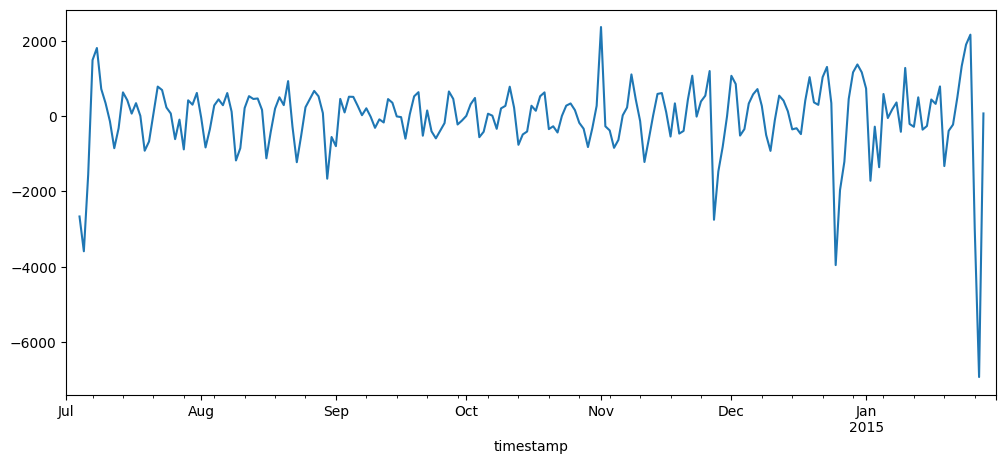

In [57]:
residuos = tx_decomposed.resid
residuos.plot()
plt.show()

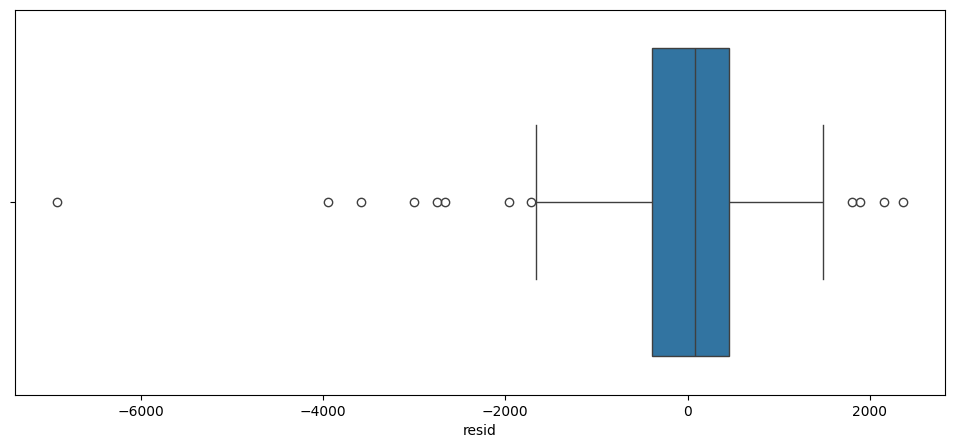

In [58]:
sns.boxplot(residuos, orient='h')
plt.show()

In [59]:
p25 = residuos.quantile(0.25)
p75 = residuos.quantile(0.75)
iiq = p75-p25

limite_inferior = p25-1.5*iiq
limite_superior = p75+1.5*iiq

In [60]:
residuos[residuos<limite_inferior]

timestamp
2014-07-04   -2662.358614
2014-07-05   -3584.863178
2014-11-27   -2749.361409
2014-12-25   -3950.956647
2014-12-26   -1961.903257
2015-01-02   -1715.897305
2015-01-26   -2998.314071
2015-01-27   -6917.734805
Name: resid, dtype: float64

## ML e Séries Temporais

In [61]:
import sktime
import statsmodels as sm
import matplotlib 
import sklearn

In [62]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


In [77]:
path = Path('../dados/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']

daily_temp.index.freq = 'D'


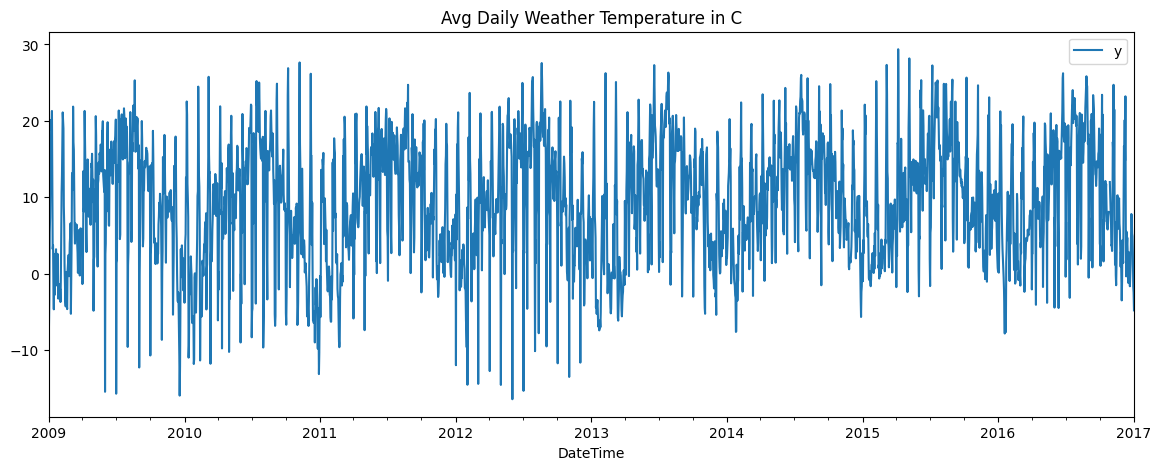

In [78]:
plt.rcParams["figure.figsize"] = [14, 5]  
daily_temp.plot(title='Avg Daily Weather Temperature in C')
plt.show()

In [ ]:
daily_temp_copy = daily_temp.copy()

In [79]:
handle_missing_data(daily_temp_copy)

In [80]:
daily_temp_os = one_step_forecast(daily_temp_copy, 5)
print(daily_temp_os.shape)

(2918, 6)


In [81]:
daily_temp_os

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847
...,...,...,...,...,...,...
2016-12-23,1.245069,4.539514,7.798611,7.527431,5.245625,4.887153
2016-12-24,4.539514,7.798611,7.527431,5.245625,4.887153,2.676250
2016-12-25,7.798611,7.527431,5.245625,4.887153,2.676250,-1.706597


## Treinando modelos de ML em dados no tempo

In [82]:
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)

In [83]:
dw_cp = daily_temp.copy()

In [84]:
handle_missing_data(dw_cp)

found 2 missing observations...


In [85]:
dw_reg = one_step_forecast(dw_cp, 10)
dw_reg

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
DateTime,,,,,,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847,3.210903
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847,3.210903,3.682431
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847,3.210903,3.682431,-1.678194
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847,3.210903,3.682431,-1.678194,-4.687778
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847,3.210903,3.682431,-1.678194,-4.687778,-0.060972
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-18,2.805833,2.494306,-0.617431,-1.665556,-0.007361,1.245069,4.539514,7.798611,7.527431,5.245625,4.887153
2016-12-19,2.494306,-0.617431,-1.665556,-0.007361,1.245069,4.539514,7.798611,7.527431,5.245625,4.887153,2.676250
2016-12-20,-0.617431,-1.665556,-0.007361,1.245069,4.539514,7.798611,7.527431,5.245625,4.887153,2.676250,-1.706597


In [86]:
train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

In [87]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [88]:
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:659: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:671: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:659: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/danielferreira/miniconda3/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:671: UserWarni

In [89]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.655729,1.083826,0.968735
0,Linear Regression,0.646648,1.037424,0.990057
2,Ridge Regression,0.646639,1.037273,0.990085
1,Elastic Net,0.737896,0.913599,1.300792
3,Lasso Regression,0.814609,0.911730,1.468567
